# Procedure for quantum state preparation (QSP) experiment.

QSP is presented clearly in [this publication](https://arxiv.org/abs/2306.17422). The basic idea is that we have two unitary $U(\theta)$ and $V^{\dagger}$, we optimize the parameter $\theta$ until $\theta^{*}$ such that $U(\theta^{*})V^{\dagger}=I$.

So we will do experiments with various $U$, $V^{\dagger}$ and optimize strategy. 

Some notation for hyperparameter:

(important)
- Ansatz: $U$ (defined in `qtm.ansatz`)
- Optimize circuit: $u$ (ansatz when repeat $L$ times)
- State: $V^{\dagger}$ (defined in `qtm.state`)
- Number of qubit: $n$ (`num_qubits`)
- Number of layer (for ansatz): $L$ (`num_layers`)
- $\theta$: theta (if $\theta$ is scalar), thetas (if $\theta$ is 1-d numpy array) and thetass (if $\theta$ is 2-d numpy array).

(not important)
- Number of iteration: $n_{iter}$ (`num_iter / iter`)
- Optimizer: `sgd`, `adam` or `qng` family, the best optimizer is `adam`.

Here is your task, run the below codes with:

- $U$ is `qtm.ansatz.g2`, `qtm.ansatz.g2gn` or `qtm.ansatz.g2gnw`.
- $V^{\dagger}$ is `qtm.state.create_GHZ_state(num_qubits).inverse()`, `qtm.state.create_W_state(num_qubits).inverse()`, `qtm.state.create_AME_state(num_qubits).inverse()` or `qtm.state.create_haar_state_inverse(num_qubits)`
- $n$ from 3 - 10 (3 - 5 for AME state).
- $L$ from 1 - 10 (Note: if we run L = 3 and achieve fidelity ~ 0, then no need to run with larger $L$).
- $n_{iter}$: default is 100, if loss value is not ~ 0, you can plot loss_values curve by compiler.plot() method, if it can decrease in the next iteration, then increasing $n_{iter}$ upto 300.

The detailed guideline is below. If you can use the server A6000, let's view `multi_process_script.py`.

In [1]:
import sys
sys.path.insert(0, '..')
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state
from qsee.backend import constant, utilities
import matplotlib.pyplot as plt
import numpy as np, qiskit
%load_ext autoreload
%autoreload 2

### Quantum State Preparation (QSP) problem

First, using Quantum Compilation (QC) to find optimized $\theta$

In [2]:
def custom_ansatz(num_qubits: int) -> qiskit.QuantumCircuit:
    qc = qiskit.QuantumCircuit(num_qubits)
    thetas = qiskit.circuit.ParameterVector("theta", 2 * num_qubits)
    j = 0
    for i in range(num_qubits):
        qc.rx(thetas[j], i)
        qc.rz(thetas[j + 1], i)
        j += 2
    return qc


qsp = QuantumStatePreparation(
    u=custom_ansatz(2),
    target_state=state.w(num_qubits=2).inverse(),
).fit(
    num_steps=20,
    optimizer="adam",
    # metrics_func=["loss_basic", "compilation_trace_fidelities"],
    metrics_func=constant.DEFAULT_COMPILATION_METRICS
)

In [4]:
qsp.compiler.metrics

{'loss_fubini_study': [0.9170059977993601,
  0.8963258336118624,
  0.8588946384743591,
  0.8284322543213778,
  0.7940403012442127,
  0.7725930364687479,
  0.7431688906298487,
  0.7252585745787499,
  0.7083784299369935,
  0.7102816342831905,
  0.70164093381159,
  0.714142842854285,
  0.7078841713161836,
  0.7128113354878695,
  0.7177743377970545,
  0.7166589146867567,
  0.7160307255977217,
  0.7146327728281148,
  0.714072825417688,
  0.7030647196382421],
 'compilation_trace_fidelities': [0.15664709975568109,
  0.20613699655917359,
  0.2589561113189878,
  0.3126047577474207,
  0.36414707709039174,
  0.41032495130149665,
  0.4483429701711734,
  0.4759346604155505,
  0.49253120699726183,
  0.49939700779910223,
  0.49918183371254077,
  0.4952124567251459,
  0.49041188487514015,
  0.48686842161045835,
  0.4855567956167248,
  0.48631311951723616,
  0.4887927378300459,
  0.49214106521834583,
  0.49545953435112994,
  0.49802161586599814],
 'compilation_trace_distances': [0.9183424770366381,
  0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


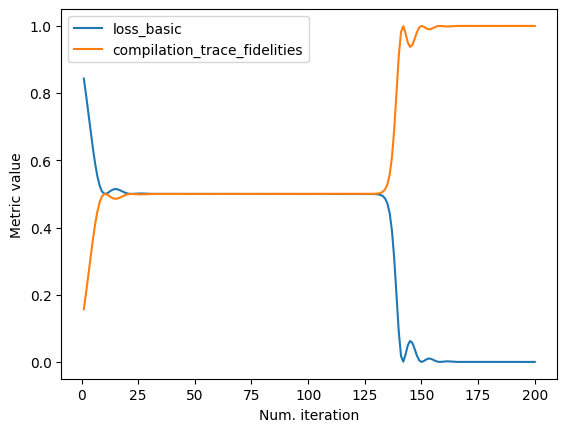

In [41]:
qsp.plot(filename = 'fig3.c')

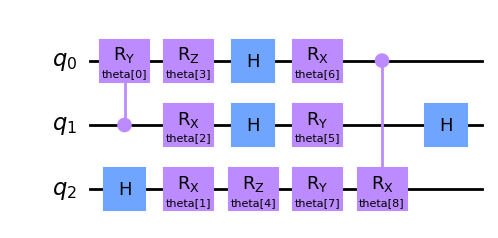

In [19]:
from qsee.core import random_circuit
random_circuit.generate_with_pool(3, 5).draw('mpl')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


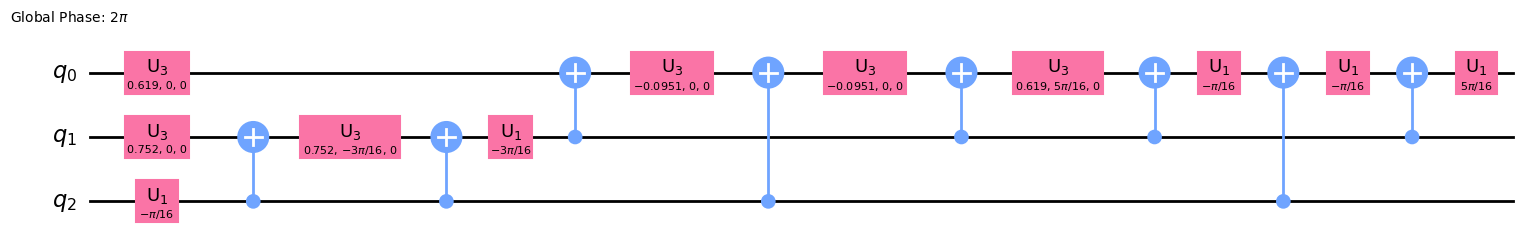

In [10]:
from qiskit.providers.fake_provider import FakeQasmSimulator
backend = FakeQasmSimulator()
qc = qiskit.QuantumCircuit(3)
target_state = {
    "000": 1 / np.sqrt(2),
    "001": 1j / np.sqrt(6),
    "010": -1j / np.sqrt(3),
    "011": (1 + 1j) / (2 * np.sqrt(2)),
}
qc = state.specific([1 / np.sqrt(2), 1j / np.sqrt(6), -1j / np.sqrt(3), (1 + 1j) / (2 * np.sqrt(2)),
                  0, 0, 0, 0])
qc1 = qiskit.transpile(qc, backend)
qc1.draw('mpl', filename = 'custom.eps')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


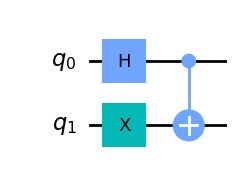

In [5]:
qc = qiskit.QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cx(0,1)
qc.draw('mpl', filename = 'w2.eps')

In [31]:
qsp = QuantumStatePreparation(
    u=ansatz.g2gnw(3,1),
    target_state=state.w(num_qubits=3).inverse(),
).fit(
    num_steps=100,
    optimizer="adam",
    metrics_func=["loss_basic", "compilation_trace_fidelities"],
)

In [28]:
np.savetxt('loss4.txt', qsp.compiler.metrics["compilation_trace_fidelities"])

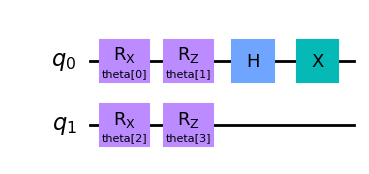

In [11]:
custom_ansatz(num_qubits=2).compose(state.w(num_qubits=2).inverse()).draw(
    "mpl", filename="circuit.svg"
)

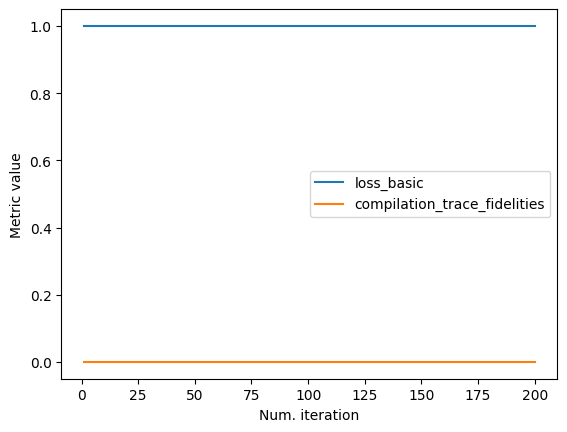

In [174]:
qsp.plot()

In [85]:
theta = np.pi / 2
u = np.array(
    [
        [1, 0, 0, 0],
        [0, np.cos(theta), 0, np.sin(theta)],
        [0, 0, 1, 0],
        [0, np.sin(theta), 0, -np.cos(theta)],
    ]
)
compiler = QuantumStatePreparation.prepare(u)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


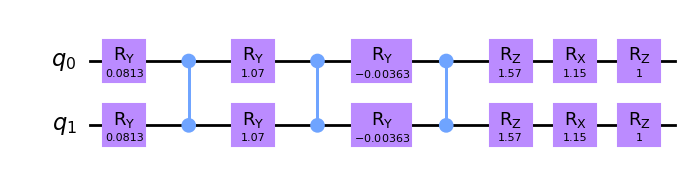

In [77]:
compiler.u.assign_parameters(compiler.thetas).draw("mpl")

In [20]:
num_qubits = 2
num_layers = 1
qsp = QuantumStatePreparation(
    u=ansatz.g2gn(num_qubits, num_layers),
    target_state=state.w(num_qubits=2).inverse(),
).fit(50)

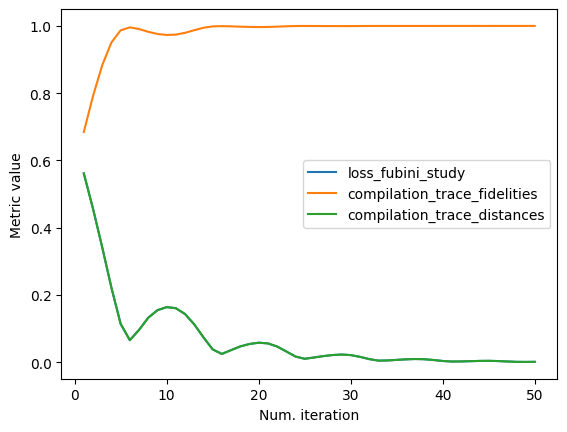

In [21]:
qsp.compiler.plot()

In [143]:
import numpy as np

target_state = {
    "000": 1 / np.sqrt(2),
    "001": 1j / np.sqrt(6),
    "010": -1j / np.sqrt(3),
    "011": (1 + 1j) / (2 * np.sqrt(2)),
}
compiler = QuantumStatePreparation.prepare(target_state)

In [45]:
num_qubits = 2
num_layers = 1
qsp = QuantumStatePreparation(
    u=compiler.u,
    target_state=state.w(num_qubits=3).inverse(),
).fit()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


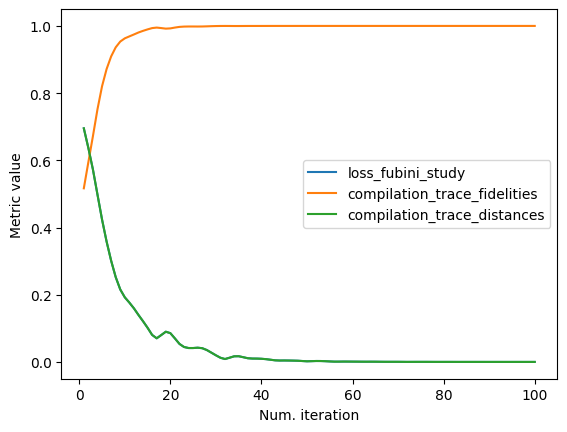

In [46]:
qsp.plot(filename='uw3_plot')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


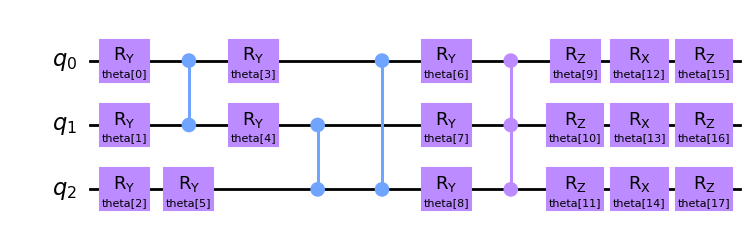

In [146]:
compiler.u.draw('mpl', filename='circuit_psi2.eps')

In [43]:

compiler = QuantumStatePreparation.prepare('w', num_qubits = 3, error_rate = 0.001)

     ┌──────────────┐                ┌──────────────┐      ┌──────────────┐   
q_0: ┤ Ry(theta[0]) ├───────■────────┤ Ry(theta[3]) ├────■─┤ Ry(theta[6]) ├─■─
     ├──────────────┤       │        ├──────────────┤    │ ├──────────────┤ │ 
q_1: ┤ Ry(theta[1]) ├───────■────────┤ Ry(theta[4]) ├─■──┼─┤ Ry(theta[7]) ├─■─
     ├──────────────┤┌──────────────┐└──────────────┘ │  │ ├──────────────┤ │ 
q_2: ┤ Ry(theta[2]) ├┤ Ry(theta[5]) ├─────────────────■──■─┤ Ry(theta[8]) ├─■─
     └──────────────┘└──────────────┘                      └──────────────┘   
can prepare the state w 3 qubits >= 0.999 fidelity (0.9999561765943481)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


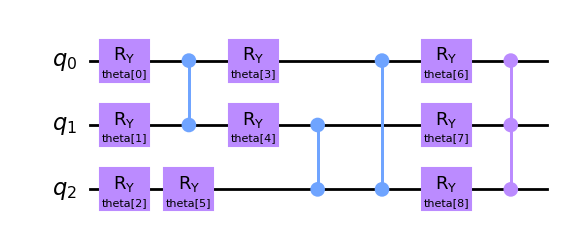

In [44]:
compiler.u.draw('mpl', filename = 'uw3.eps')

In [48]:
from qsee.compilation.qsp import QuantumStatePreparation

target_state = np.array(np.random.uniform(size=2**3))
compiler = QuantumStatePreparation.prepare(target_state, error_rate=0.1)

Default compiler is not sastify your error rate, please use other ansatz in QuantumCompilationObj


**Important**, you must save the result in the folder experiments/qsp/, where the 'state' argument is the name of state which is need to prepare. The name of file will be automatically create followed this format:

```
[state]_[ansatz]_[num_qubits]_[num_layers].qspobj
```

Last step, load QSP from saved file and check its properties.

In [36]:
qspobj = QuantumStatePreparation.load("../experiments/test")
qspobj.fidelity

0.9998482451406707

In [8]:
obj = QuantumStatePreparation.prepare("ghz", num_qubits=3)

     ┌──────────────┐                ┌──────────────┐      ┌──────────────┐   
q_0: ┤ Ry(theta[0]) ├───────■────────┤ Ry(theta[3]) ├────■─┤ Ry(theta[6]) ├─■─
     ├──────────────┤       │        ├──────────────┤    │ ├──────────────┤ │ 
q_1: ┤ Ry(theta[1]) ├───────■────────┤ Ry(theta[4]) ├─■──┼─┤ Ry(theta[7]) ├─■─
     ├──────────────┤┌──────────────┐└──────────────┘ │  │ ├──────────────┤ │ 
q_2: ┤ Ry(theta[2]) ├┤ Ry(theta[5]) ├─────────────────■──■─┤ Ry(theta[8]) ├─■─
     └──────────────┘└──────────────┘                      └──────────────┘   
can prepare the state ghz 3 qubits >= 0.99 fidelity (0.9998482451406707)


In [35]:
obj.save("../experiments/test")